# This notebook will explore the airbnb data from Mex. City


 Importing the necessary packages and loading the datasets

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

In [2]:
calendar_df = pd.read_csv('../raw_data/mexico/calendar.csv')
list_df = pd.read_csv('../raw_data/mexico/listings.csv')
rev_df = pd.read_csv('../raw_data/mexico/reviews.csv')

### Displaying the first three rows of every dataframe(df) in order to know the tables

In [4]:
list_df.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,35797,Villa Dante,153786,Dici,NaN,Cuajimalpa de Morelos,19.38283,-99.27178,Entire home/apt,4123,1,0,NaN,NaN,1,363,0,NaN
1,44616,CONDESA HAUS B&B,196253,Condesa Haus Bed & Breakfast CDMX,NaN,Cuauhtémoc,19.41162,-99.17794,Entire home/apt,15000,1,50,2021-08-23,0.41,10,344,1,NaN
2,56074,Great space in historical San Rafael,265650,Maris,NaN,Cuauhtémoc,19.43977,-99.15605,Entire home/apt,600,2,66,2021-11-21,0.50,2,364,10,NaN


In [5]:
calendar_df.head(3)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,2084093,2021-12-26,f,$453.00,$453.00,1.0,1125.0
1,35797,2021-12-26,f,"$4,123.00","$4,123.00",1.0,7.0
2,35797,2021-12-27,f,"$4,123.00","$4,123.00",1.0,7.0


In [7]:
rev_df.head()

,listing_id,date
0,44616,2011-11-09
1,44616,2012-08-16
2,44616,2012-12-28
3,44616,2013-01-04
4,44616,2013-03-19


we observe that the listings table has it's own information as well as some processed information from the reviews and calendar tables. At the same time, the reviews table has the date of each individual review per id.

In [15]:
 #rev_df.groupby(by=['listing_id']).count().sort_values(by='date')

In [77]:
#checking the data types

list_df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
number_of_reviews_ltm               int64
dtype: object

## Listing table cleaning
we can see there are some columns with null values, so i will se how much of that is usefull so we have a dataset prepared for some modelling.

Before doing any modifications, let's whats the shape of the table.

In [52]:
list_df.shape

(19655, 16)

Lets see if there is any duplicated row and eventually remove it.

In [55]:
list_df.duplicated().sum()
#No duplicates

0

In [29]:
print((list_df.isnull().sum()/len(list_df)*100).sort_values(ascending=False))

license                           100.000000
neighbourhood_group               100.000000
reviews_per_month                  20.234037
last_review                        20.234037
name                                0.015263
host_name                           0.005088
number_of_reviews                   0.000000
number_of_reviews_ltm               0.000000
availability_365                    0.000000
calculated_host_listings_count      0.000000
id                                  0.000000
minimum_nights                      0.000000
room_type                           0.000000
longitude                           0.000000
latitude                            0.000000
neighbourhood                       0.000000
host_id                             0.000000
price                               0.000000
dtype: float64


**MISSING DATA!!**

summing all the Null ocurrences per column and dividing it by the length of the columns we can have the percentage of null values per column. It is a good practice to get rid off any column with more than 30-35% of null values (if they are not specified to mean something). So, i will drop the 'license' and 'neighbourhood_group' columns.

For the rest of the columns, i will input them values or replace the null value for some place holder.

### Dropping and imputing missing values

I will use the simple imputer module from scikit learn to impute the values

In [32]:
#dropping columns and saving the changes into the same table
list_df.drop(columns=['license', 'neighbourhood_group'], inplace=True)

In [47]:
#replacing null values in name and host_name columns to 'no_name' value.
list_df['name'].replace(np.nan, 'no_name', inplace=True)
list_df['host_name'].replace(np.nan, 'no_name', inplace=True)

In [73]:
#inputing values for last_review and reviews_per_month. In this case, we will input the most common date for last_review and input and average for reviews_per_month for all null values.


freq_imp = SimpleImputer(strategy='most_frequent')

#fitting and transforming the data, replacing null values with the most frequent last review date

list_df['last_review'] = freq_imp.fit_transform(list_df.filter(items=['last_review']))


In [69]:
mean_imp = SimpleImputer(strategy='mean')

#fitting and transforming the data, replacing the null values with the mean value of reviews per month

list_df['reviews_per_month'] = mean_imp.fit_transform(list_df.filter(items=['reviews_per_month']))

We can see now that the missing values are gone, every null value has been removed or replaced with an imputation

In [74]:
print((list_df.isnull().sum()/len(list_df)*100).sort_values(ascending=False))

id                                0.0
name                              0.0
host_id                           0.0
host_name                         0.0
neighbourhood                     0.0
latitude                          0.0
longitude                         0.0
room_type                         0.0
price                             0.0
minimum_nights                    0.0
number_of_reviews                 0.0
last_review                       0.0
reviews_per_month                 0.0
calculated_host_listings_count    0.0
availability_365                  0.0
number_of_reviews_ltm             0.0
dtype: float64


### Looking for outliers
I will see if there are any notable outliers and eventually drop them in order to make the data more balanced.
This will be done for numerical columns such as price, coordinates, number of reviews among others.

Text(0.5, 1.0, 'num_rev_ltm')

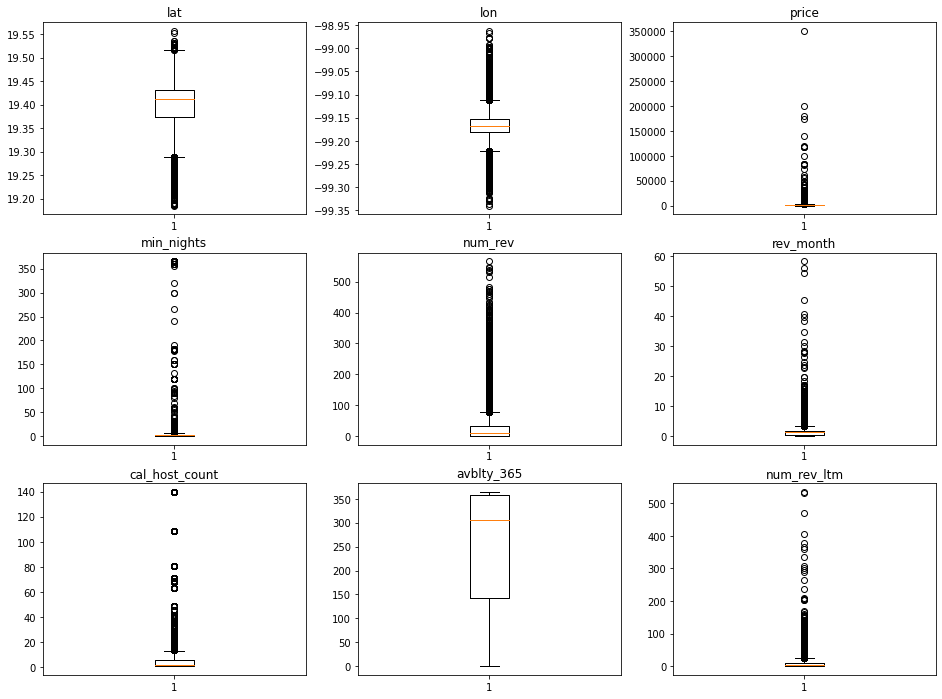

In [95]:
fig, axs = plt.subplots(3,3, figsize=(16,12))

axs[0,0].boxplot(list_df[['latitude']])
axs[0,0].set_title('lat')
axs[0,1].boxplot(list_df[['longitude']])
axs[0,1].set_title('lon')
axs[0,2].boxplot(list_df[['price']])
axs[0,2].set_title('price')

axs[1,0].boxplot(list_df[['minimum_nights']])
axs[1,0].set_title('min_nights')
axs[1,1].boxplot(list_df[['number_of_reviews']])
axs[1,1].set_title('num_rev')
axs[1,2].boxplot(list_df[['reviews_per_month']])
axs[1,2].set_title('rev_month')

axs[2,0].boxplot(list_df[['calculated_host_listings_count']])
axs[2,0].set_title('cal_host_count')
axs[2,1].boxplot(list_df[['availability_365']])
axs[2,1].set_title('avblty_365')
axs[2,2].boxplot(list_df[['number_of_reviews_ltm']])
axs[2,2].set_title('num_rev_ltm')



We can see every column but avaiabiliy 365 have outliers, fortunately most of it follows a linear incremental pattern. For example, this is expected with latitude and longitude, since they are numeric variables that changes with distance. 

I will make some further examination into price and reviews column to eliminate those outliers

/home/drifter/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price', ylabel='number_of_reviews'>

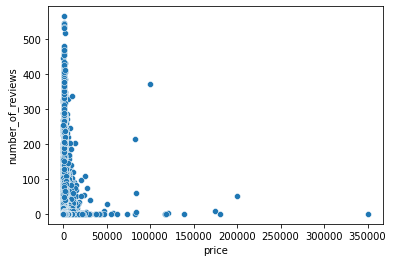

In [109]:
sns.scatterplot(list_df['price'],list_df['number_of_reviews'])

In [118]:
list_df['price'].sort_values()

11994         0
11923         0
11975         0
11997         0
11995         0
          ...  
16647    139138
9426     174285
11087    180000
7860     200000
4614     350000
Name: price, Length: 19655, dtype: int64

In [140]:
len(list_df.loc[list_df['price'] < 5])

6

In [162]:
(list_df['price'] <= 135).sum()

7

We can see there are 6 rows with a pricetag of 6 pesos per night, we will 

### Scaling the data
Now, to understand the distribution of our data, and eventually which selecting the adequate scaler, i will plot an histogram for every numerical column.

Text(0.5, 1.0, 'num_rev_ltm')

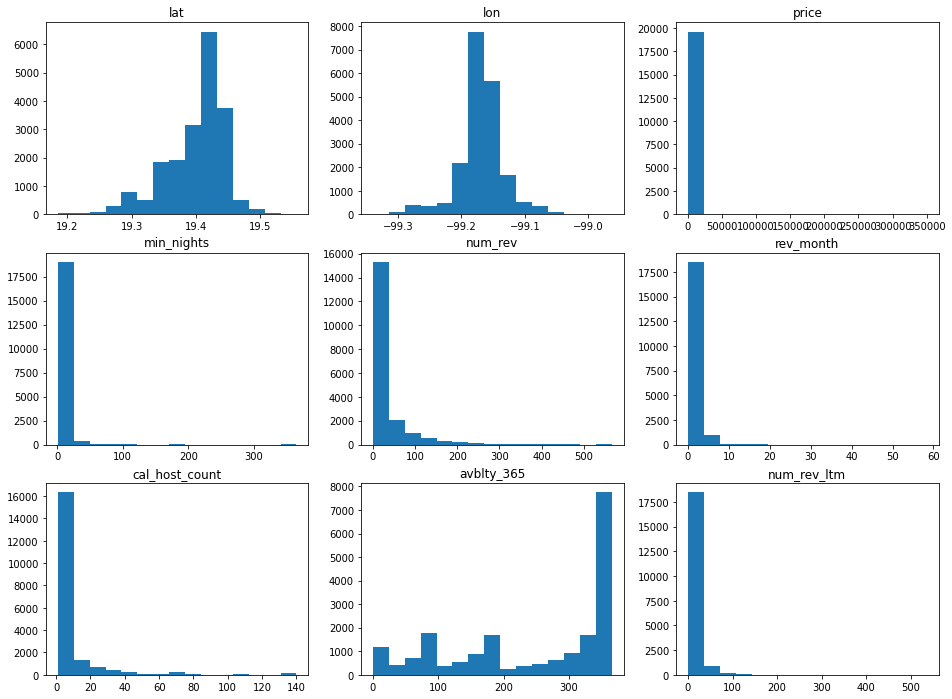

In [103]:
fig, axs = plt.subplots(3,3, figsize=(16,12))

axs[0,0].hist(list_df[['latitude']], bins=15)
axs[0,0].set_title('lat')
axs[0,1].hist(list_df[['longitude']], bins=15)
axs[0,1].set_title('lon')
axs[0,2].hist(list_df[['price']], bins=15)
axs[0,2].set_title('price')

axs[1,0].hist(list_df[['minimum_nights']], bins=15)
axs[1,0].set_title('min_nights')
axs[1,1].hist(list_df[['number_of_reviews']], bins=15)
axs[1,1].set_title('num_rev')
axs[1,2].hist(list_df[['reviews_per_month']], bins=15)
axs[1,2].set_title('rev_month')

axs[2,0].hist(list_df[['calculated_host_listings_count']], bins=15)
axs[2,0].set_title('cal_host_count')
axs[2,1].hist(list_df[['availability_365']], bins=15)
axs[2,1].set_title('avblty_365')
axs[2,2].hist(list_df[['number_of_reviews_ltm']], bins=15)
axs[2,2].set_title('num_rev_ltm')

<AxesSubplot:xlabel='price', ylabel='Count'>

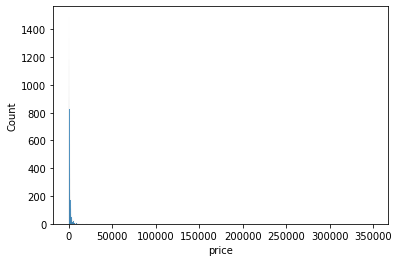

In [104]:
sns.histplot(list_df['price'])